In [2]:
#Import model
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from tqdm.notebook import tqdm

from PIL import Image

#import warnings
#warnings.filterwarnings('ignore')


from tensorflow.keras.utils import plot_model

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Input,BatchNormalization,Activation, GlobalAveragePooling2D, Add
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

#Librairie to split dataset
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, mean_absolute_error

#For model Xception
from tensorflow.keras.applications import Xception

#For model VGG19
from tensorflow.keras.applications import VGG19  

# For model ResNet152V2
from tensorflow.keras.applications import ResNet152V2 

#For model InceptionResNetV2 
from tensorflow.keras.applications import InceptionResNetV2

#For model MobileNetV2
from tensorflow.keras.applications import MobileNetV2

#For model DenseNet201
from tensorflow.keras.applications import DenseNet201

#For model NASNetLarge 
from tensorflow.keras.applications import NASNetLarge 

#For model EfficientNetB7 
from tensorflow.keras.applications import EfficientNetB7 

#For model EfficientNetV2L 
from tensorflow.keras.applications import EfficientNetV2L 

#For model ConvNeXtXLarge
from tensorflow.keras.applications import ConvNeXtXLarge 

In [3]:
#Load the dataset
BASE_DIR = '../input/utkface-new/UTKFace/'

In [4]:
#label Age, gender and Ethnicity
images_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temps = filename.split("_")
    ages = int(temps[0])
    genders = int(temps[1])
    
    images_paths.append(image_path)
    age_labels.append(ages)
    gender_labels.append(genders)
    
    #print(images_paths)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
#transform the dataset to dataFrame
data = pd.DataFrame()

data['image'], data['age'], data['gender'] = images_paths, age_labels, gender_labels
data.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


In [6]:
data.size

71124

In [7]:
#map label for gender
gender_dic = {0: 'Male', 1:'Femel'}

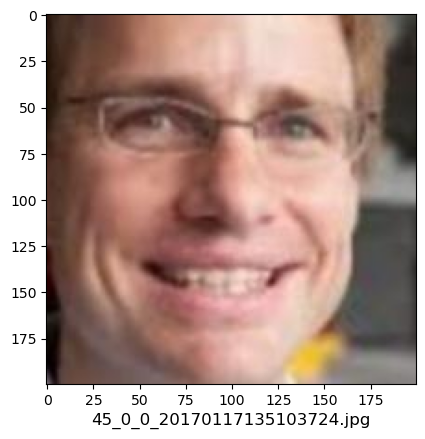

In [8]:
image_path = data['image'][130]

# Display the image
img = Image.open(image_path)
plt.imshow(img)

# Extract image name and extension
image_name = image_path.split('/')[-1].split('.')[0]  # Adjust the path delimiter if needed
image_extension = image_path.split('.')[-1]

# Add text to display image name and extension
text = f"{image_name}.{image_extension}"
plt.text(0.5, -0.1, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, color='black')

# Show the plot
plt.show()


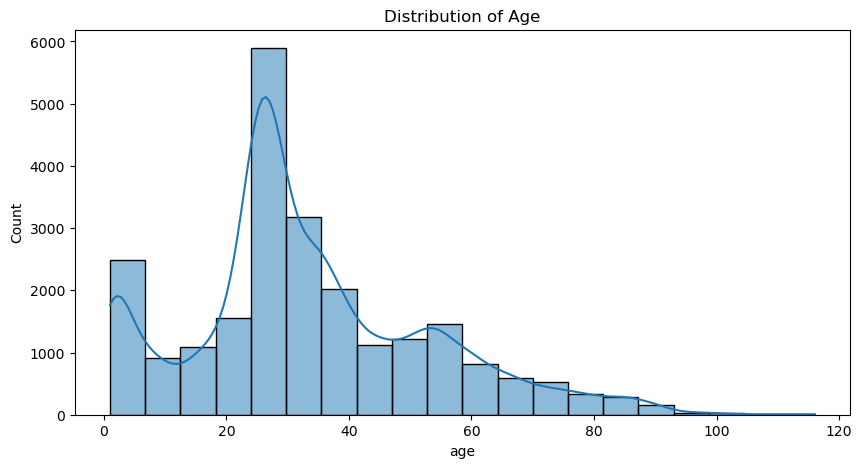

In [9]:
#Diplay the distribution of age and also of the gender 

# Plot the distribution of age using a histogram
plt.figure(figsize=(10, 5))
 
sns.histplot(data=data, x='age', bins=20, kde=True)
plt.title('Distribution of Age')
 

plt.show()


In [ ]:
#scalar the age distribution

# Create an instance of MinMaxScaler
#scaler = MinMaxScaler()
# Reshape the 'age' column to a 2D array
#new_ages = data['age'].values.reshape(-1, 1)
# Fit the scaler to the 'age' column and compute the minimum and maximum values
#scaler.fit(new_ages)
# Transform the 'age' data using the computed minimum and maximum values
#scaled_age = scaler.transform(new_ages)

# Replace the original 'age' column with the scaled values
#data['age'] = scaled_age

# Print the first few rows of the modified dataset
#print(data.head())

In [ ]:
# Plot the distribution of age after scaler
#plt.figure(figsize=(10, 5))
 
#sns.histplot(data=data, x='age', bins=20, kde=True)
#plt.title('Distribution of Age After scaled age')
 

#plt.show()

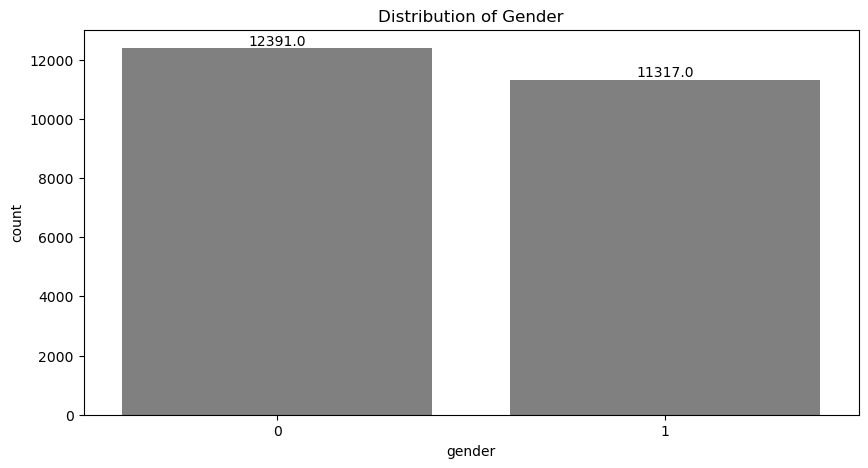

In [10]:
# Plot the distribution of gender using a count plot
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=data, x='gender', color='gray')
plt.title('Distribution of Gender')

# Add count numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()


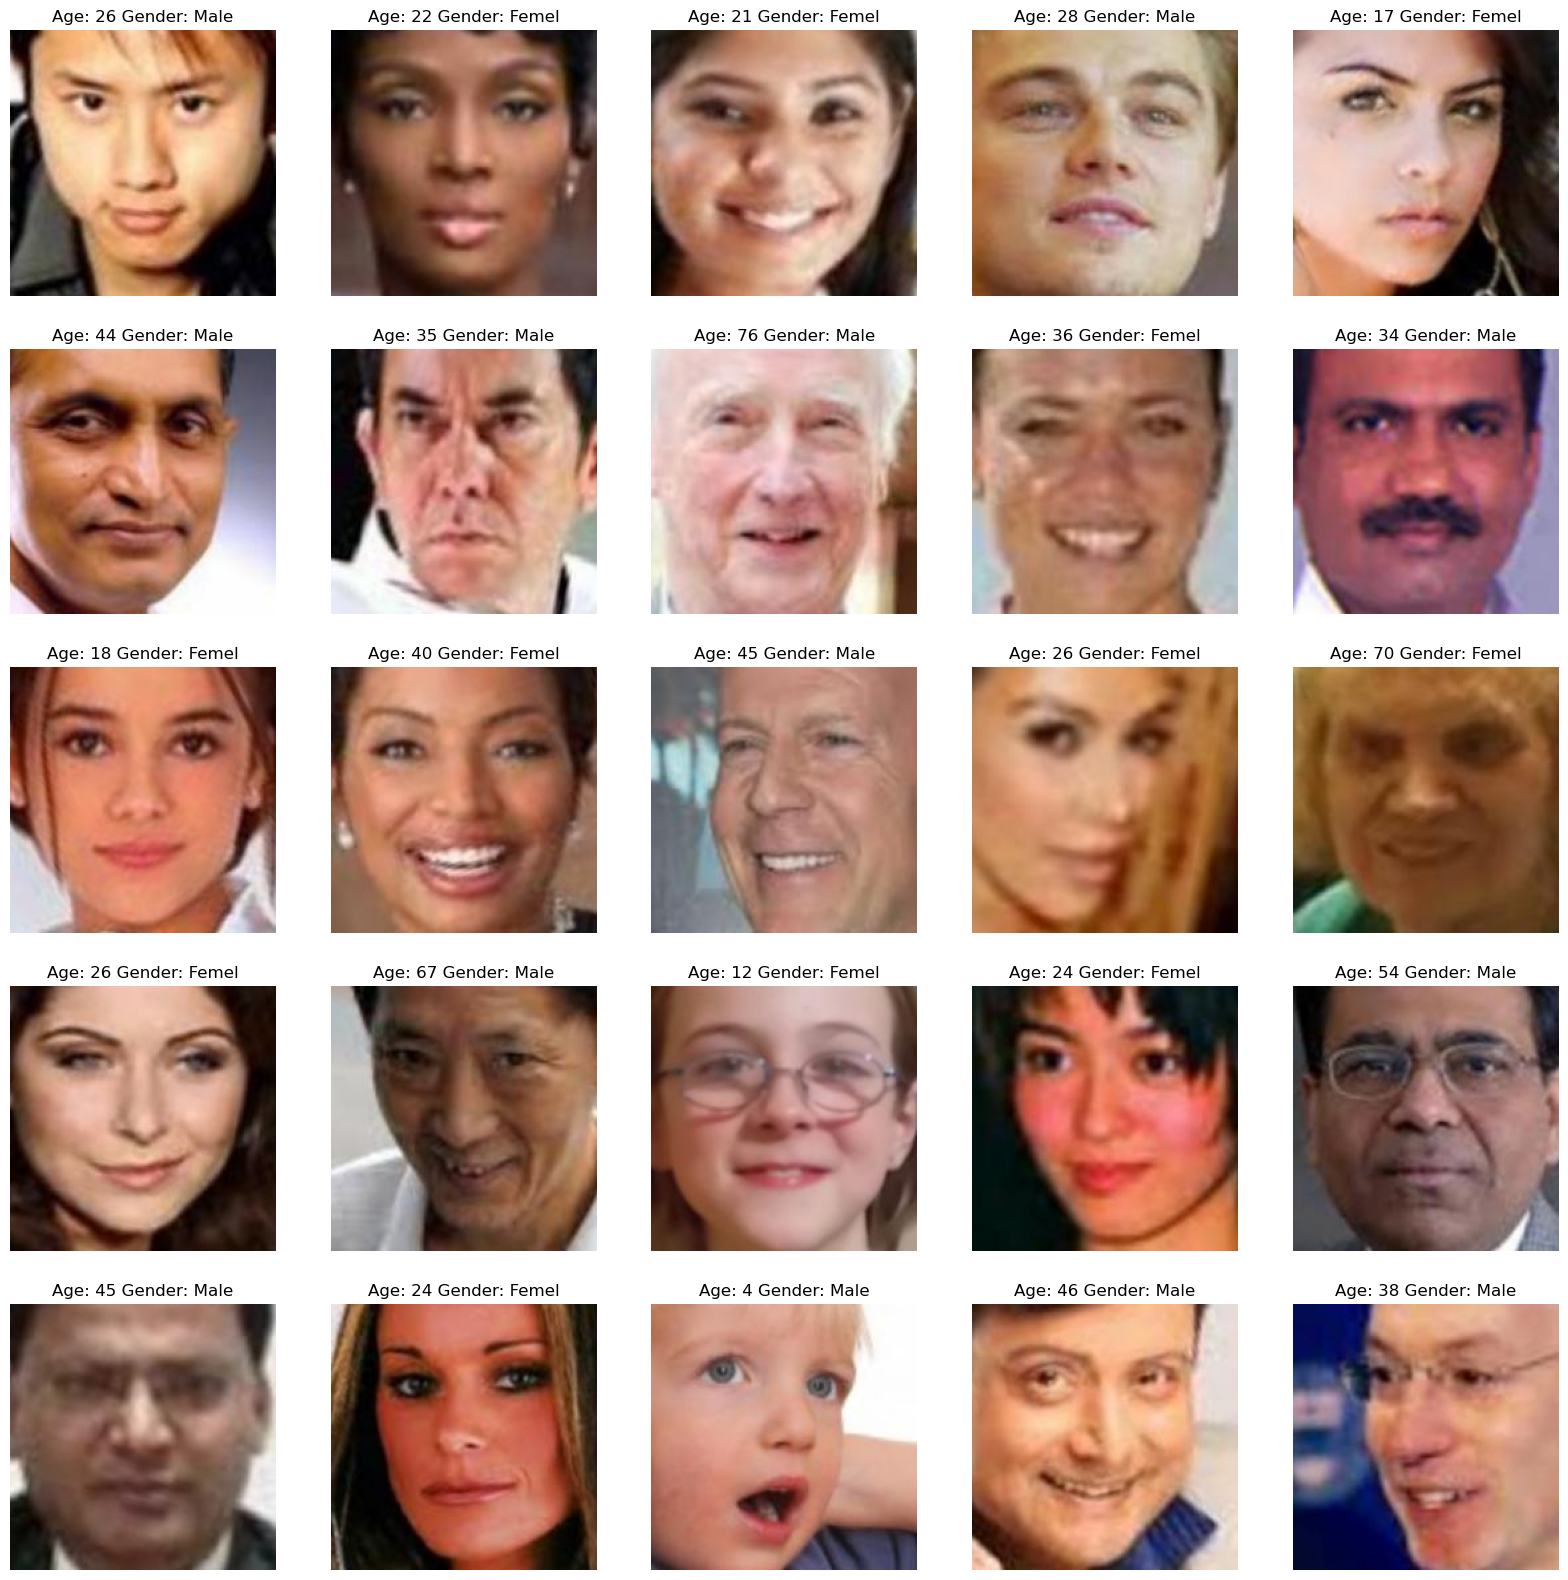

In [11]:
# Assuming gender_dict is a dictionary that maps gender codes (0 and 1) to gender labels ('Female' and 'Male')

# to display grid of images
plt.figure(figsize=(20, 20))
files = data.iloc[0:25]

# Filter data to get only the younger individuals
#files_younger = data[data['age'] < 30].iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img =  Image.open(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dic[gender]}")
    plt.axis('off')

plt.show()

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')  # Convert to grayscale
        img = img.resize((128, 128), Image.LANCZOS)  # Use LANCZOS for resizing
        features.append(np.array(img))  # Convert the image to a NumPy array

    # Check the shapes of the images in the features list
    shapes = set(img.shape for img in features)
    if len(shapes) > 1:
        raise ValueError("Images have different sizes or shapes.")

    features = np.array(features)
    # Reshape the features array to add the channel dimension (1 for grayscale)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [13]:
# Assuming 'data' is your DataFrame containing image paths in the 'image' column
Extractions = extract_features(data['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
Extractions.shape

(23708, 128, 128, 1)

In [15]:
#Normalize the extraction
Extractions = Extractions /255.0

In [16]:
y_gender = np.array(data['gender'])
y_age = np.array(data['age'])

In [17]:
input_shape = (128, 128, 1)

In [18]:

# Split the dataset into training and validation sets
X_train, X_val, y_gender_train, y_gender_val, y_age_train, y_age_val = train_test_split(
    Extractions, y_gender, y_age, test_size=0.2, random_state=42)
 

In [ ]:
#create Xception model

input_shape_xception = input_shape

# Load the Xception model pre-trained on ImageNet data
base_model = Xception(weights=None, include_top=False, input_shape=input_shape_xception)

# Specify the local path to the Xception weights file
weights_path_Xception = '../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load weights locally
#base_model.load_weights(weights_path_Xception)
base_model.load_weights(weights_path_Xception, by_name=True)


# Set the convolutional base to be non-trainable (freeze the weights)
base_model.trainable = False
# summarize the base model architecture
#base_model.summary()
print("****************************************************************")
# Input layer
input_layer = Input(shape=input_shape_xception)


# Pass through Xception base model
inputs = base_model(input_layer)

# Add custom convolutional layers with reduced downsampling
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(1, 1))(conv_1)
conv_2 = Conv2D(64, kernel_size=(1, 1), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(1, 1))(conv_2)
conv_3 = Conv2D(128, kernel_size=(1, 1), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(1, 1))(conv_3)
conv_4 = Conv2D(256, kernel_size=(1, 1), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(1, 1))(conv_4)

# Flatten and add custom dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation="relu")(flatten)
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dropout_1)

# Output layer for age prediction (using linear activation for regression)
output_age = Dense(1, activation='linear', name='output_age')(dropout_1)

# Create the Xception model with custom layers
xception_model = Model(inputs=input_layer, outputs=[output_gender, output_age])

# Print a summary of the model architecture
xception_model.summary()

# Compile the model
xception_model.compile(optimizer=Adam(),
                               loss=['binary_crossentropy', 'mean_absolute_error'],
                               metrics=['accuracy'])


In [ ]:
# plot the Xception model  
plot_model(xception_model, to_file='xception_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the Xception model  
history1 = xception_model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=10, validation_data=(X_val, [y_gender_val, y_age_val]))

In [ ]:
##Plot the Results
# plot results for gender
acc = history1.history['output_gender_accuracy']
val_acc = history1.history['val_output_gender_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy') 
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

print("-----------------------------------------------------------------------------------------")
# plot results for gender
loss = history1.history['output_gender_loss']
val_loss = history1.history['val_output_gender_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

print("-----------------------------------------------------------------------------------------")
# plot results for age
loss = history1.history['output_age_loss']
val_loss = history1.history['val_output_age_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
#The prediction with xception model 
##Test 1
#Prediction with Test Data
image_index = 100
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = xception_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 2
#Prediction with Test Data
image_index = 980
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = xception_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');



In [ ]:
##Test 3
#Prediction with Test Data
image_index = 666
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = xception_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
#Create a VGG16 model
input_shape_vgg19 = input_shape

# Load the VGG19 model pre-trained on ImageNet data
base_model = VGG19(weights=None, include_top=False, input_shape=input_shape_vgg19)

# Specify the local path to the VGG19 weights file
weights_path_VGG19 = '../input/vgg19-weights-tf-dim-ordering-tf-kernels-notop-h5/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load weights locally
base_model.load_weights(weights_path_VGG19, by_name=True, skip_mismatch=True)
# Set the convolutional base to be non-trainable (freeze the weights)
base_model.trainable = False
# Let's take a look at the base model architecture
#base_model.summary()
print("****************************************************************")

# Input layer
input_layer = Input(shape=input_shape_vgg19)
 
# Pass through VGG19 base model
inputs = base_model(input_layer)

# Add custom convolutional layers with reduced downsampling
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(1, 1))(conv_1)
conv_2 = Conv2D(64, kernel_size=(1, 1), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(1, 1))(conv_2)
conv_3 = Conv2D(128, kernel_size=(1, 1), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(1, 1))(conv_3)
conv_4 = Conv2D(256, kernel_size=(1, 1), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(1, 1))(conv_4)

# Flatten and add custom dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation="relu")(flatten)
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dropout_1)

# Output layer for age prediction (using linear activation for regression)
output_age = Dense(1, activation='linear', name='output_age')(dropout_1)

# Create the VGG19 model with custom layers
vgg19_model = Model(inputs=input_layer, outputs=[output_gender, output_age])

# Print a summary of the model architecture
vgg19_model.summary()

# Compile the model
vgg19_model.compile(optimizer=Adam(),
                            loss=['binary_crossentropy', 'mean_absolute_error'],
                            metrics=['accuracy'])



In [ ]:
# plot the vgg19_model model  
plot_model(vgg19_model, to_file='vgg19_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the vgg19 model  
history2 = vgg19_model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=10, validation_data=(X_val, [y_gender_val, y_age_val]))


In [ ]:
##Plot the Results
# plot results for gender
acc = history2.history['output_gender_accuracy']
val_acc = history2.history['val_output_gender_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

print("-----------------------------------------------------------------------------------------")
# plot results for gender
loss = history2.history['output_gender_loss']
val_loss = history2.history['val_output_gender_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

print("-----------------------------------------------------------------------------------------")
# plot results for age
loss = history2.history['output_age_loss']
val_loss = history2.history['val_output_age_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
#The prediction with vgg19 model 
##Test 1
#Prediction with Test Data
image_index = 100
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = vgg19_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');


In [ ]:
##Test 2
#Prediction with Test Data
image_index = 980
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = vgg19_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
#The prediction with xception model 
##Test 3
#Prediction with Test Data
image_index = 666
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = vgg19_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');


In [ ]:
#create a ResNet152V2
input_shape_resnet152v2 = input_shape

# Load the ResNet152V2 model pre-trained on ImageNet data
base_model = ResNet152V2(weights=None, include_top=False, input_shape=input_shape_resnet152v2)

# Specify the local path to the ResNet152V2 weights file
weights_path_restNet = '../input/resnet152v2/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load weights locally
base_model.load_weights(weights_path_restNet, by_name=True, skip_mismatch=True)

# Set the convolutional base to be non-trainable (freeze the weights)
base_model.trainable = False
# summarize the base model architecture
#base_model.summary()
print("****************************************************************")
# Input layer
input_layer_resnet152v2 = Input(shape=input_shape_resnet152v2)

# Pass through ResNet152V2 base model 
output_resnet152v2 = base_model(input_layer_resnet152v2)

# Add custom convolutional layers with reduced downsampling 
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(output_resnet152v2)
maxp_1 = MaxPooling2D(pool_size=(1, 1))(conv_1)
conv_2 = Conv2D(64, kernel_size=(1, 1), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(1, 1))(conv_2)
conv_3 = Conv2D(128, kernel_size=(1, 1), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(1, 1))(conv_3)
conv_4 = Conv2D(256, kernel_size=(1, 1), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(1, 1))(conv_4)

# Flatten and add custom dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation="relu")(flatten)
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dropout_1)

# Output layer for age prediction (using linear activation for regression)
output_age = Dense(1, activation='linear', name='output_age')(dropout_1)

# Create the ResNet152V2 model with custom layers
resnet152v2_model = Model(inputs=input_layer_resnet152v2, outputs=[output_gender, output_age])

# Print a summary of the model architecture
resnet152v2_model.summary()

# Compile the model
resnet152v2_model.compile(optimizer=Adam(),
                          loss=['binary_crossentropy', 'mean_absolute_error'],
                          metrics=['accuracy'])


In [ ]:
# plot the resnet152v2 model  
plot_model(resnet152v2_model, to_file='resnet152v2_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the resnet152v2 model  
history3 = resnet152v2_model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=10, validation_data=(X_val, [y_gender_val, y_age_val]))

In [ ]:
##Plot the Results
# plot results for gender
acc = history3.history['output_gender_accuracy']
val_acc = history3.history['val_output_gender_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

print("-----------------------------------------------------------------------------------------")
# plot results for gender
loss = history3.history['output_gender_loss']
val_loss = history3.history['val_output_gender_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

print("-----------------------------------------------------------------------------------------")
# plot results for age
loss = history3.history['output_age_loss']
val_loss = history3.history['val_output_age_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
#The prediction with resnet152v2 model 
##Test 1
#Prediction with Test Data
image_index = 100
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = resnet152v2_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 2
#Prediction with Test Data
image_index = 980
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = resnet152v2_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 3
#Prediction with Test Data
image_index = 666
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = resnet152v2_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [19]:
#Create  InceptionResNetV2 model
 
input_shape_inception = input_shape

# Load the InceptionResNetV2 model pre-trained on ImageNet data
base_model = InceptionResNetV2(weights=None, include_top=False, input_shape=input_shape_inception)

# Specify the local path to the InceptionResNetV2 weights file
weights_path_InceptionResNetV2 = '../input/inception-resnet-v2-weights/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load weights locally
base_model.load_weights(weights_path_InceptionResNetV2, by_name=True, skip_mismatch=True)

# Set the convolutional base to be non-trainable (freeze the weights)
base_model.trainable = False
# summarize the base model architecture
#base_model.summary()
print("****************************************************************")
# Input layer
input_layer = Input(shape=input_shape_inception)
 
# Pass through InceptionResNetV2 base model
output_resnet152v2 = base_model(input_layer)

# Add custom convolutional layers with reduced downsampling
conv_1 = Conv2D(32, kernel_size=(2, 2), activation='relu')(output_resnet152v2)
maxp_1 = MaxPooling2D(pool_size=(1, 1))(conv_1)
conv_2 = Conv2D(64, kernel_size=(1, 1), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(1, 1))(conv_2)
conv_3 = Conv2D(128, kernel_size=(1, 1), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(1, 1))(conv_3)
conv_4 = Conv2D(256, kernel_size=(1, 1), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(1, 1))(conv_4)

# Flatten and add custom dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation="relu")(flatten)
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dropout_1)

# Output layer for age prediction (using linear activation for regression)
output_age = Dense(1, activation='linear', name='output_age')(dropout_1)

# Create the InceptionResNetV2 model with custom layers
inception_model = Model(inputs=input_layer, outputs=[output_gender, output_age])

# Print a summary of the model architecture
inception_model.summary()

# Compile the model
inception_model.compile(optimizer=Adam(),
                               loss=['binary_crossentropy', 'mean_absolute_error'],
                               metrics=['accuracy'])



****************************************************************
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 2, 2, 1536)  54336160    ['input_2[0][0]']                
 l)                                                                                               
                                                                                                  
 conv2d_203 (Conv2D)            (None, 1, 1, 32)     196640      ['inception_resnet_v2[0][0]']    
                             

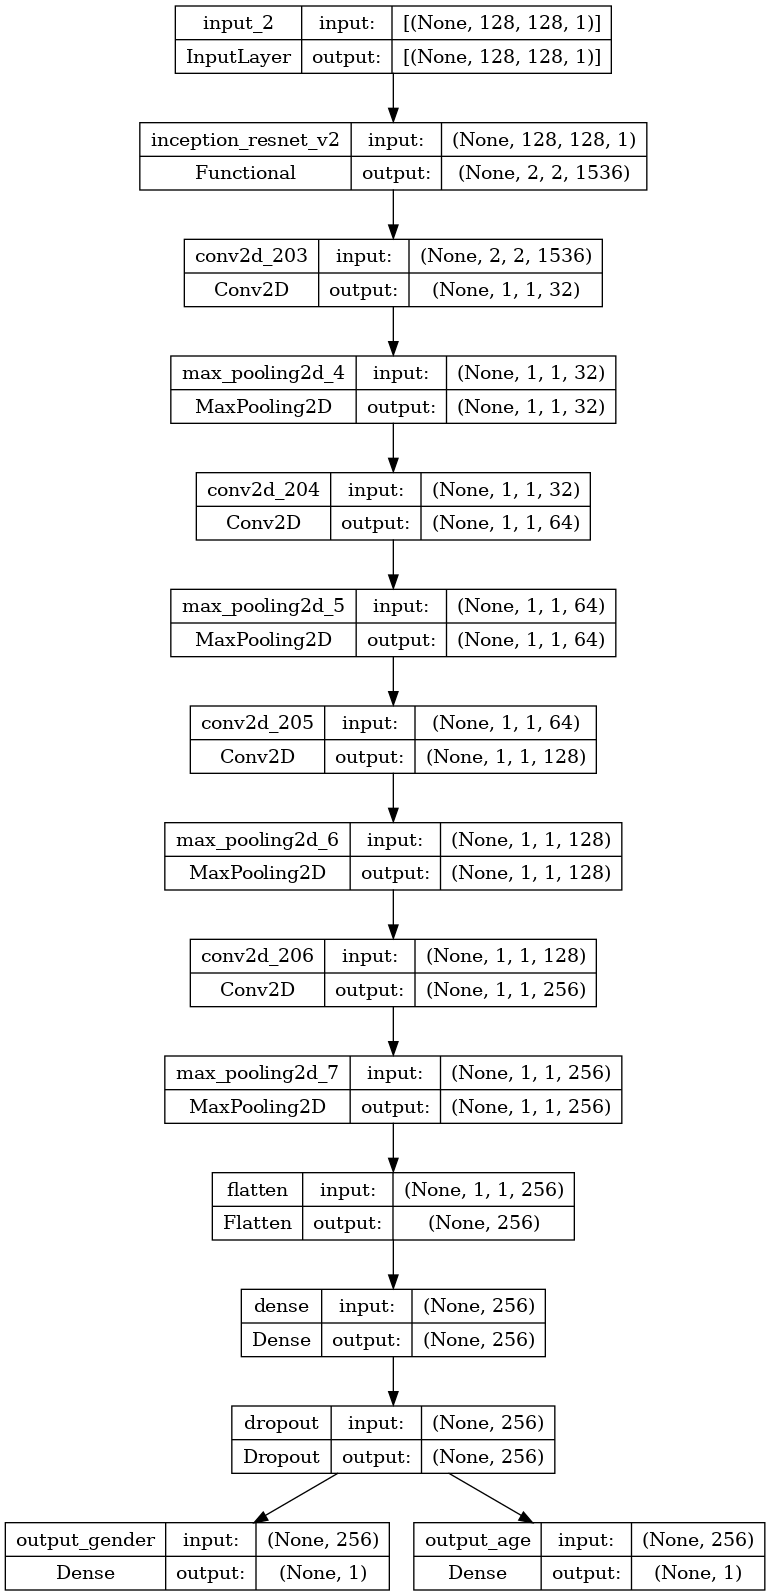

In [20]:
# plot the InceptionResNetV2 model  
plot_model(inception_model, to_file='InceptionResNetV2.png', show_shapes=True, show_layer_names=True)

In [21]:
# Train the InceptionResNetV2 model  
history4 = inception_model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=10, validation_data=(X_val, [y_gender_val, y_age_val]))


Epoch 1/10
593/593 [==============================] - 512s 848ms/step - loss: 16.8153 - output_gender_loss: 0.8008 - output_age_loss: 16.0145 - output_gender_accuracy: 0.4964 - output_age_accuracy: 0.0463 - val_loss: 14.4330 - val_output_gender_loss: 0.6870 - val_output_age_loss: 13.7461 - val_output_gender_accuracy: 0.5272 - val_output_age_accuracy: 0.0481
Epoch 2/10
593/593 [==============================] - 543s 916ms/step - loss: 14.4678 - output_gender_loss: 0.6981 - output_age_loss: 13.7697 - output_gender_accuracy: 0.5196 - output_age_accuracy: 0.0472 - val_loss: 13.5475 - val_output_gender_loss: 0.7033 - val_output_age_loss: 12.8442 - val_output_gender_accuracy: 0.4728 - val_output_age_accuracy: 0.0481
Epoch 3/10
593/593 [==============================] - 544s 918ms/step - loss: 13.4880 - output_gender_loss: 0.6849 - output_age_loss: 12.8031 - output_gender_accuracy: 0.5497 - output_age_accuracy: 0.0470 - val_loss: 14.5818 - val_output_gender_loss: 0.7184 - val_output_age_loss:

-----------------------------------------------------------------------------------------


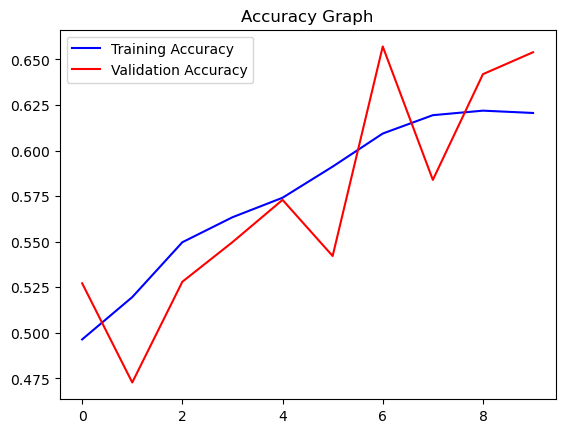

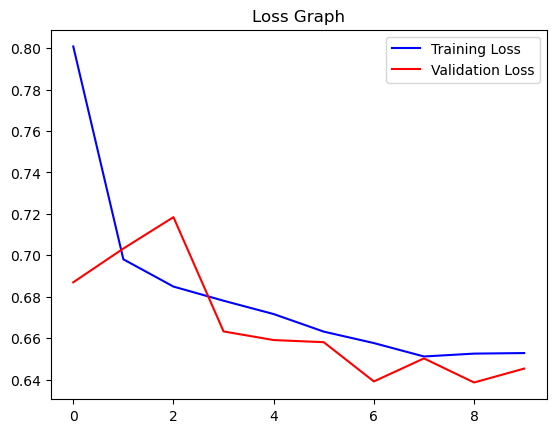

-----------------------------------------------------------------------------------------


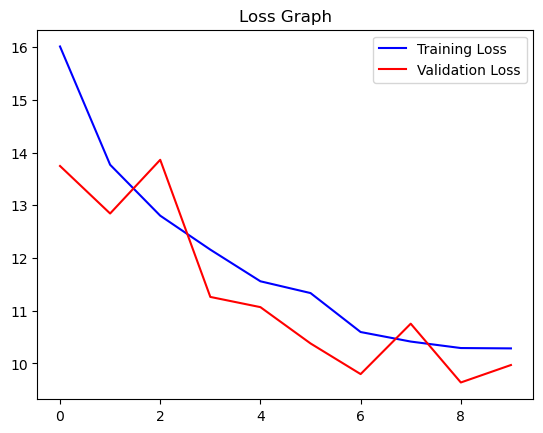

In [22]:
##Plot the Results
# plot results for gender
acc = history4.history['output_gender_accuracy']
val_acc = history4.history['val_output_gender_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

print("-----------------------------------------------------------------------------------------")
# plot results for gender
loss = history4.history['output_gender_loss']
val_loss = history4.history['val_output_gender_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

print("-----------------------------------------------------------------------------------------")
# plot results for age
loss = history4.history['output_age_loss']
val_loss = history4.history['val_output_age_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Femel Original Age: 3
1/1 [==============================] - 3s 3s/step
Predicted Gender: Femel Predicted Age: 5


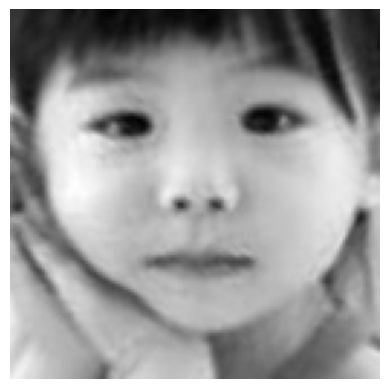

In [23]:
#The prediction with InceptionResNetV2 model 
##Test 1
#Prediction with Test Data
image_index = 100
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = inception_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 37
1/1 [==============================] - 0s 78ms/step
Predicted Gender: Male Predicted Age: 33


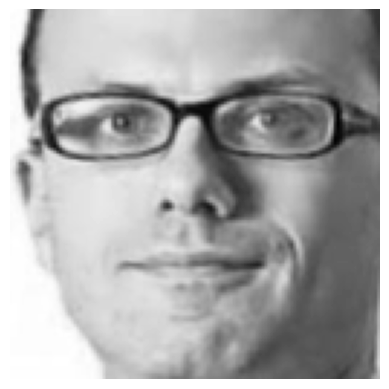

In [24]:
##Test 2
#Prediction with Test Data
image_index = 980
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = inception_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

Original Gender: Femel Original Age: 26
1/1 [==============================] - 0s 59ms/step
Predicted Gender: Femel Predicted Age: 28


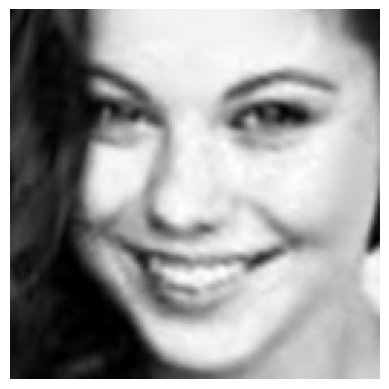

In [25]:
##Test 3
#Prediction with Test Data
image_index = 666
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = inception_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
#Create model MobileNetV2

input_shape_mobilenet = input_shape

# Load the MobileNetV2 model pre-trained on ImageNet data
base_model = MobileNetV2(weights=None, include_top=False, input_shape=input_shape_mobilenet)
 

# Specify the local path to the MobileNetV2 weights file
weights_path_MobileNetV2 = '../input/mobilenet-v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

# Load weights locally
base_model.load_weights(weights_path_MobileNetV2, by_name=True, skip_mismatch=True)



# Set the convolutional base to be non-trainable (freeze the weights)
base_model.trainable = False
# summarize the base model architecture
#base_model.summary()
print("****************************************************************")
# Input layer
input_layer = Input(shape=input_shape_mobilenet)
 
# Pass through MobileNetV2 base model
inputs_MobileNetV2 = base_model(input_layer)

# Add custom convolutional layers with reduced downsampling
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs_MobileNetV2)
maxp_1 = MaxPooling2D(pool_size=(1, 1))(conv_1)
conv_2 = Conv2D(64, kernel_size=(1, 1), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(1, 1))(conv_2)
conv_3 = Conv2D(128, kernel_size=(1, 1), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(1, 1))(conv_3)
conv_4 = Conv2D(256, kernel_size=(1, 1), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(1, 1))(conv_4)

# Flatten and add custom dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation="relu")(flatten)
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dropout_1)

# Output layer for age prediction (using linear activation for regression)
output_age = Dense(1, activation='linear', name='output_age')(dropout_1)

# Create the MobileNetV2 model with custom layers
mobilenet_model = Model(inputs=input_layer, outputs=[output_gender, output_age])

# Print a summary of the model architecture
mobilenet_model.summary()

# Compile the model
mobilenet_model.compile(optimizer=Adam(),
                               loss=['binary_crossentropy', 'mean_absolute_error'],
                               metrics=['accuracy'])


In [ ]:
# plot the mobilenet model  
plot_model(mobilenet_model, to_file='MobileNetV2.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the mobilenet model  
history5 = mobilenet_model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=10, validation_data=(X_val, [y_gender_val, y_age_val]))


In [ ]:
##Plot the Results
# plot results for gender
acc = history5.history['output_gender_accuracy']
val_acc = history5.history['val_output_gender_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

print("-----------------------------------------------------------------------------------------")
# plot results for gender
loss = history5.history['output_gender_loss']
val_loss = history5.history['val_output_gender_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

print("-----------------------------------------------------------------------------------------")
# plot results for age
loss = history5.history['output_age_loss']
val_loss = history5.history['val_output_age_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
#The prediction with MobileNetV2 model 
##Test 1
#Prediction with Test Data
image_index = 100
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = mobilenet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 2
#Prediction with Test Data
image_index = 980
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = mobilenet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 3
#Prediction with Test Data
image_index = 666
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = mobilenet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
#Create model DenseNet201
input_shape_densenet = input_shape

# Load the DenseNet201 model pre-trained on ImageNet data
base_model = DenseNet201(weights=None, include_top=False, input_shape=input_shape_densenet)

# Specify the local path to the DenseNet201 weights file
weights_path_DenseNet201 = '../input/densenet201/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load weights locally
base_model.load_weights(weights_path_DenseNet201, by_name=True, skip_mismatch=True)

# Set the convolutional base to be non-trainable (freeze the weights)
base_model.trainable = False
# summarize the base model architecture
#base_model.summary()
print("****************************************************************")
# Input layer
input_layer = Input(shape=input_shape_densenet)
 
# Pass through DenseNet201 base model
inputs_DenseNet201 = base_model(input_layer)

# Add custom convolutional layers with reduced downsampling 
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs_DenseNet201)
maxp_1 = MaxPooling2D(pool_size=(1, 1))(conv_1)
conv_2 = Conv2D(64, kernel_size=(1, 1), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(1, 1))(conv_2)
conv_3 = Conv2D(128, kernel_size=(1, 1), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(1, 1))(conv_3)
conv_4 = Conv2D(256, kernel_size=(1, 1), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(1, 1))(conv_4)

# Flatten and add custom dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation="relu")(flatten)
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dropout_1)

# Output layer for age prediction (using linear activation for regression)
output_age = Dense(1, activation='linear', name='output_age')(dropout_1)

# Create the DenseNet201 model with custom layers
densenet_model = Model(inputs=input_layer, outputs=[output_gender, output_age])

# Print a summary of the model architecture
densenet_model.summary()

# Compile the model
densenet_model.compile(optimizer=Adam(),
                               loss=['binary_crossentropy', 'mean_absolute_error'],
                               metrics=['accuracy'])



In [ ]:
# plot the DenseNet201 model  
plot_model(densenet_model, to_file='densenet_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the DenseNet201 model  
history6 = densenet_model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=10, validation_data=(X_val, [y_gender_val, y_age_val]))


In [ ]:
##Plot the Results
# plot results for gender
acc = history6.history['output_gender_accuracy']
val_acc = history6.history['val_output_gender_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

print("-----------------------------------------------------------------------------------------")
# plot results for gender
loss = history6.history['output_gender_loss']
val_loss = history6.history['val_output_gender_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

print("-----------------------------------------------------------------------------------------")
# plot results for age
loss = history6.history['output_age_loss']
val_loss = history6.history['val_output_age_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
#The prediction with DenseNet201 model 
##Test 1
#Prediction with Test Data
image_index = 100
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = densenet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 2
#Prediction with Test Data
image_index = 980
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = densenet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 3
#Prediction with Test Data
image_index = 666
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = densenet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
#Create model NASNetLarge
 
input_shape_nasnet = input_shape

# Load the NASNetLarge model pre-trained on ImageNet data
base_model = NASNetLarge(weights=None, include_top=False, input_shape=input_shape_nasnet)

# Specify the local path to the NASNetLarge weights file
weights_path_NASNetLarge = '../input/nasnet-large/NASNet-large-no-top.h5'

# Load weights locally
base_model.load_weights(weights_path_NASNetLarge, by_name=True, skip_mismatch=True)


# Set the convolutional base to be non-trainable (freeze the weights)
base_model.trainable = False
# summarize the base model architecture
#base_model.summary()
print("****************************************************************")
# Input layer
input_layer = Input(shape=input_shape_nasnet)
 

# Pass through NASNetLarge base model
inputs_NASNetLarge = base_model(input_layer)

# Add custom convolutional layers with reduced downsampling
conv_1 = Conv2D(32, kernel_size=(2, 2), activation='relu')(inputs_NASNetLarge)
maxp_1 = MaxPooling2D(pool_size=(1, 1))(conv_1)
conv_2 = Conv2D(64, kernel_size=(1, 1), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(1, 1))(conv_2)
conv_3 = Conv2D(128, kernel_size=(1, 1), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(1, 1))(conv_3)
conv_4 = Conv2D(256, kernel_size=(1, 1), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(1, 1))(conv_4)

# Flatten and add custom dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation="relu")(flatten)
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dropout_1)

# Output layer for age prediction (using linear activation for regression)
output_age = Dense(1, activation='linear', name='output_age')(dropout_1)

# Create the NASNetLarge model with custom layers
nasnet_model = Model(inputs=input_layer, outputs=[output_gender, output_age])

# Print a summary of the model architecture
nasnet_model.summary()

# Compile the model
nasnet_model.compile(optimizer=Adam(),
                            loss=['binary_crossentropy', 'mean_absolute_error'],
                            metrics=['accuracy'])



In [ ]:
# plot the nasnet model  
plot_model(nasnet_model, to_file='NASNetLarge.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the NASNetLarge model  
history7 = nasnet_model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=10, validation_data=(X_val, [y_gender_val, y_age_val]))


In [ ]:
##Plot the Results
# plot results for gender
acc = history7.history['output_gender_accuracy']
val_acc = history7.history['val_output_gender_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

print("-----------------------------------------------------------------------------------------")
# plot results for gender
loss = history7.history['output_gender_loss']
val_loss = history7.history['val_output_gender_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

print("-----------------------------------------------------------------------------------------")
# plot results for age
loss = history7.history['output_age_loss']
val_loss = history7.history['val_output_age_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
#The prediction with NASNetLarge model 
##Test 1
#Prediction with Test Data
image_index = 100
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = nasnet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 2
#Prediction with Test Data
image_index = 980
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = nasnet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 3
#Prediction with Test Data
image_index = 666
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = nasnet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
#For model EfficientNetB7
input_shape_efficientnet = input_shape

# Load the EfficientNetB7 model pre-trained on ImageNet data
base_model = EfficientNetB7(weights=None, include_top=False, input_shape=input_shape_efficientnet)

# Specify the local path to the EfficientNetB7 weights file
weights_path_EfficientNetB7 = '../input/efficientnetb7/efficientnetb7_notop.h5'

# Load weights locally
base_model.load_weights(weights_path_EfficientNetB7, by_name=True, skip_mismatch=True)

# Set the convolutional base to be non-trainable (freeze the weights)
base_model.trainable = False
# summarize the base model architecture
#base_model.summary()
print("****************************************************************")
# Input layer
input_layer = Input(shape=input_shape_efficientnet)
 

# Pass through EfficientNetB7 base model
inputs_EfficientNetB7 = base_model(input_layer)

# Add custom convolutional layers with reduced downsampling
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs_EfficientNetB7)
maxp_1 = MaxPooling2D(pool_size=(1, 1))(conv_1)
conv_2 = Conv2D(64, kernel_size=(1, 1), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(1, 1))(conv_2)
conv_3 = Conv2D(128, kernel_size=(1, 1), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(1, 1))(conv_3)
conv_4 = Conv2D(256, kernel_size=(1, 1), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(1, 1))(conv_4)

# Flatten and add custom dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation="relu")(flatten)
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dropout_1)

# Output layer for age prediction (using linear activation for regression)
output_age = Dense(1, activation='linear', name='output_age')(dropout_1)

# Create the EfficientNetB7 model with custom layers
efficientnet_model = Model(inputs=input_layer, outputs=[output_gender, output_age])

# Print a summary of the model architecture
efficientnet_model.summary()

# Compile the model
efficientnet_model.compile(optimizer=Adam(),
                                  loss=['binary_crossentropy', 'mean_absolute_error'],
                                  metrics=['accuracy'])


In [ ]:
# plot the efficientnet model  
plot_model(efficientnet_model, to_file='efficientnet_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the efficientnet model  
history8 = efficientnet_model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=10, validation_data=(X_val, [y_gender_val, y_age_val]))


In [ ]:
##Plot the Results
# plot results for gender
acc = history8.history['output_gender_accuracy']
val_acc = history8.history['val_output_gender_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

print("-----------------------------------------------------------------------------------------")
# plot results for gender
loss = history8.history['output_gender_loss']
val_loss = history8.history['val_output_gender_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

print("-----------------------------------------------------------------------------------------")
# plot results for age
loss = history8.history['output_age_loss']
val_loss = history8.history['val_output_age_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
#The prediction with xception model 
##Test 1
#Prediction with Test Data
image_index = 100
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = efficientnet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 2
#Prediction with Test Data
image_index = 980
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = efficientnet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 3
#Prediction with Test Data
image_index = 666
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = efficientnet_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
#Create the model EfficientNetV2L
input_shape_efficientnet = input_shape

# Load the EfficientNetV2L model pre-trained on ImageNet data
base_model = EfficientNetV2L(weights=None, include_top=False, input_shape=input_shape_efficientnet)

# Specify the local path to the EfficientNetB7 weights file
weights_path_EfficientNetV2L = '../input/efficientnetv2-l/efficientnetv2-l_notop.h5'

# Load weights locally
base_model.load_weights(weights_path_EfficientNetV2L, by_name=True, skip_mismatch=True)


# Set the convolutional base to be non-trainable (freeze the weights)
base_model.trainable = False
# summarize the base model architecture
#base_model.summary()
print("****************************************************************")
# Input layer
input_layer = Input(shape=input_shape_efficientnet)
 
# Pass through EfficientNetV2L base model
intputs_EfficientNetV2L = base_model(input_layer)

# Add custom convolutional layers with reduced downsampling
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(intputs_EfficientNetV2L)
maxp_1 = MaxPooling2D(pool_size=(1, 1))(conv_1)
conv_2 = Conv2D(64, kernel_size=(1, 1), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(1, 1))(conv_2)
conv_3 = Conv2D(128, kernel_size=(1, 1), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(1, 1))(conv_3)
conv_4 = Conv2D(256, kernel_size=(1, 1), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(1, 1))(conv_4)

# Flatten and add custom dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation="relu")(flatten)
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dropout_1)

# Output layer for age prediction (using linear activation for regression)
output_age = Dense(1, activation='linear', name='output_age')(dropout_1)

# Create the EfficientNetV2L model with custom layers
EfficientNetV2L_model = Model(inputs=input_layer, outputs=[output_gender, output_age])

# Print a summary of the model architecture
EfficientNetV2L_model.summary()

# Compile the model
EfficientNetV2L_model.compile(optimizer=Adam(),
                                  loss=['binary_crossentropy', 'mean_absolute_error'],
                                  metrics=['accuracy'])


In [ ]:
# plot the EfficientNetV2L model  
plot_model(EfficientNetV2L_model, to_file='EfficientNetV2L_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the EfficientNetV2L model  
history9 = EfficientNetV2L_model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=10, validation_data=(X_val, [y_gender_val, y_age_val]))


In [ ]:
##Plot the Results
# plot results for gender
acc = history9.history['output_gender_accuracy']
val_acc = history9.history['val_output_gender_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

print("-----------------------------------------------------------------------------------------")
# plot results for gender
loss = history9.history['output_gender_loss']
val_loss = history9.history['val_output_gender_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

print("-----------------------------------------------------------------------------------------")
# plot results for age
loss = history9.history['output_age_loss']
val_loss = history9.history['val_output_age_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
#The prediction with EfficientNetV2L_model model 
##Test 1
#Prediction with Test Data
image_index = 100
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = EfficientNetV2L_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 2
#Prediction with Test Data
image_index = 980
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = EfficientNetV2L_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 3
#Prediction with Test Data
image_index = 666
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = EfficientNetV2L_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
#Create model ConvNeXtXLarge
# Define the input shape
input_shape_ConvNeXtXLarge = input_shape

# Load the ConvNeXtXLarge model with pre-trained ImageNet weights
base_model = ConvNeXtXLarge(weights=None, input_shape=input_shape, include_top=False)
# Specify the local path to the ConvNeXtXLarge weights file
weights_path_ConvNeXtXLarge = '../input/convnext-xlarge/convnext_xlarge_notop.h5'
# Load weights locally
base_model.load_weights(weights_path_ConvNeXtXLarge, by_name=True, skip_mismatch=True)


# Set the convolutional base to be non-trainable (freeze the weights)
base_model.trainable = False
# summarize the base model architecture
#base_model.summary()
print("****************************************************************")
# Input layer
input_layer = Input(shape=input_shape_ConvNeXtXLarge)
 
# Pass through ConvNeXtXLarge base model
inputs_ConvNeXtXLarge = base_model(input_layer)

# Add custom convolutional layers with reduced downsampling
conv_1 = Conv2D(32, kernel_size=(2, 2), activation='relu')(inputs_ConvNeXtXLarge)
maxp_1 = MaxPooling2D(pool_size=(1, 1))(conv_1)
conv_2 = Conv2D(64, kernel_size=(1, 1), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(1, 1))(conv_2)
conv_3 = Conv2D(128, kernel_size=(1, 1), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(1, 1))(conv_3)
conv_4 = Conv2D(256, kernel_size=(1, 1), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(1, 1))(conv_4)

# Flatten and add custom dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation="relu")(flatten)
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dropout_1)

# Output layer for age prediction (using linear activation for regression)
output_age = Dense(1, activation='linear', name='output_age')(dropout_1)

# Create the ResNet152V2 model with custom layers
convnext_model = Model(inputs=input_layer, outputs=[output_gender, output_age])

# Print a summary of the model architecture
convnext_model.summary()
# Compile the model 

convnext_model.compile(optimizer=Adam(),
                          loss=['binary_crossentropy', 'mean_absolute_error'],
                          metrics=['accuracy'])


In [ ]:
# plot the convnext model  
plot_model(convnext_model, to_file='ConvNeXtXLarge.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the convnext model  
history10 = convnext_model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=32, validation_data=(X_val, [y_gender_val, y_age_val]))

In [ ]:
##Plot the Results
# plot results for gender
acc = history10.history['output_gender_accuracy']
val_acc = history10.history['val_output_gender_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

print("-----------------------------------------------------------------------------------------")
# plot results for gender
loss = history10.history['output_gender_loss']
val_loss = history10.history['val_output_gender_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

print("-----------------------------------------------------------------------------------------")
# plot results for age
loss = history10.history['output_age_loss']
val_loss = history10.history['val_output_age_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
#The prediction with convnext_model model 
##Test 1
#Prediction with Test Data
image_index = 100
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = convnext_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 2
#Prediction with Test Data
image_index = 980
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = convnext_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');

In [ ]:
##Test 3
#Prediction with Test Data
image_index = 666
print("Original Gender:", gender_dic[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = convnext_model.predict(Extractions[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dic[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Extractions[image_index].reshape(128, 128), cmap='gray');